In [1]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

### Food.com   Dataset
- https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions
- https://aclanthology.org/D19-1613/

In [2]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!gdown https://drive.google.com/uc?id=1dK__rulbUEGU_m68RIK7Qevc7pcpOIme
!gdown https://drive.google.com/uc?id=1dN-wpxE3V8yNVKPByHReEaswl9UNV9wj

Downloading...
From: https://drive.google.com/uc?id=1dK__rulbUEGU_m68RIK7Qevc7pcpOIme
To: /content/RAW_recipes.csv
100% 295M/295M [00:01<00:00, 162MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dN-wpxE3V8yNVKPByHReEaswl9UNV9wj
To: /content/RAW_interactions.csv
100% 349M/349M [00:02<00:00, 156MB/s]


In [45]:
raw_interactions_df = pd.read_csv('RAW_interactions.csv')
raw_interactions_df['review']= raw_interactions_df['review'].astype(str)
raw_interactions_df.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [46]:
raw_recipes_df = pd.read_csv('RAW_recipes.csv')

raw_recipes_df.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [47]:
raw_interactions_df.info()
rating_df=raw_interactions_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132367 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


In [48]:
rating_df=rating_df.dropna()

In [50]:
rating_df=rating_df[['user_id','recipe_id','date','rating']]
rating_df.rename(columns = {'user_id':'userID', 'recipe_id':'itemID'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [51]:


x = rating_df.groupby('itemID').count()['rating'] >= 40
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['itemID'].isin(userIndex)]
y = nm_rating_df.groupby('userID').count()['rating']>=60
items = y[y].index
rating_df = nm_rating_df[nm_rating_df['userID'].isin(items)]
rating_df.shape

(50686, 4)

In [52]:
contant_df=rating_df .merge( raw_recipes_df, left_on='itemID', right_on='id', how='left').fillna(0)

In [13]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

In [14]:
dict_products = {}
index = 0
for ids in sorted(product_ids):
    dict_products[ids] = index
    index += 1

In [15]:
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1

In [16]:

rating_df["itemID"] = rating_df["itemID"].astype(str)
rating_df["userID"] = rating_df["userID"].astype(str)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Prepare dataset

In [17]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [18]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

### Look at distribution of ratings

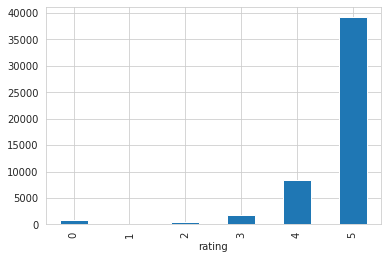

In [19]:
rating_df.groupby(['rating']).size().plot(kind = "bar")

In [20]:
!pip install tensorflow-recommenders==0.6.0

import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.9 MB/s 


### Prepare dataset for tensorflow recommenders

In [21]:
ratings = tf.data.Dataset.from_tensor_slices(dict(rating_df)).map(lambda x: {
    "userID": x["userID"],
    "itemID": x["itemID"],
    "rating": x["rating"]
})


In [22]:

items =ratings.batch(rating_df.shape[0]).map(lambda x: x["itemID"])
user_ids = ratings.batch(rating_df.shape[0]).map(lambda x: x["userID"])
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_item_ids = np.unique(np.concatenate(list(items)))
products_dict = rating_df[['itemID']].drop_duplicates()
products_dict = {name: np.array(value) for name, value in products_dict.items()}
products = tf.data.Dataset.from_tensor_slices(products_dict)
products = products.map(lambda x: x['itemID'])


In [23]:
userIds    = rating_df.userID.unique()
productIds = rating_df.itemID.unique()
total_ratings= len(rating_df.index)

In [24]:
ratings = tf.data.Dataset.from_tensor_slices( {"userID":tf.cast( rating_df.userID.values  ,tf.string),
                                "itemID":tf.cast( rating_df.itemID.values,tf.string),
                                "rating":tf.cast( rating_df.rating.values  ,tf.int8,) } )

In [25]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take( int(total_ratings*0.8) )
test = shuffled.skip(int(total_ratings*0.8)).take(int(total_ratings*0.2))

unique_productIds = productIds
unique_userIds    = userIds
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

### Tensorflow Ranking 

In [26]:
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
# Build a model.
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        self.user_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_user_ids, mask_token=None),
                                        # add addional embedding to account for unknow tokens
                                    tf.keras.layers.Embedding(len(unique_user_ids)+1, embedding_dimension)
                                    ])

        self.product_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_item_ids, mask_token=None),
                                    # add addional embedding to account for unknow tokens
                                    tf.keras.layers.Embedding(len(unique_item_ids)+1, embedding_dimension)
                                    ])
        # Set up a retrieval task and evaluation metrics over the
        # entire dataset of candidates.
        self.ratings = tf.keras.Sequential([
                            tf.keras.layers.Dense(256, activation="relu"),
                            tf.keras.layers.Dense(64,  activation="relu"),
                            tf.keras.layers.Dense(1)
                              ])
    def call(self, userId, productId):
        user_embeddings  = self.user_embeddings (userId)
        product_embeddings = self.product_embeddings(productId)
        return self.ratings(tf.concat([user_embeddings,product_embeddings], axis=1))

# Build a model.
class BuildModelRanking(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer   = tfrs.tasks.Ranking(
                                                    loss    =  tf.keras.losses.MeanSquaredError(),
                                                    metrics = [tf.keras.metrics.RootMeanSquaredError()])
            

    def compute_loss(self, features, training=False):
        rating_predictions = self.ranking_model(features["userID"], features["itemID"]  )

        return self.task( labels=features["rating"], predictions=rating_predictions)

In [27]:
modelranking = BuildModelRanking()
modelranking.compile(optimizer=tf.keras.optimizers.Adagrad( learning_rate=0.1 ))

ranking_history=modelranking.fit(cached_train, epochs=20)

Epoch 1/20
5/5 [==============================] - 3s 22ms/step - root_mean_squared_error: 3.6701 - loss: 12.6885 - regularization_loss: 0.0000e+00 - total_loss: 12.6885
Epoch 2/20
5/5 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.0845 - loss: 1.1244 - regularization_loss: 0.0000e+00 - total_loss: 1.1244
Epoch 3/20
5/5 [==============================] - 0s 6ms/step - root_mean_squared_error: 0.8596 - loss: 0.7459 - regularization_loss: 0.0000e+00 - total_loss: 0.7459
Epoch 4/20
5/5 [==============================] - 0s 5ms/step - root_mean_squared_error: 0.8396 - loss: 0.7129 - regularization_loss: 0.0000e+00 - total_loss: 0.7129
Epoch 5/20
5/5 [==============================] - 0s 5ms/step - root_mean_squared_error: 0.8317 - loss: 0.7013 - regularization_loss: 0.0000e+00 - total_loss: 0.7013
Epoch 6/20
5/5 [==============================] - 0s 6ms/step - root_mean_squared_error: 0.8297 - loss: 0.6975 - regularization_loss: 0.0000e+00 - total_loss: 0.6975
E

In [28]:
metrics = modelranking.evaluate(cached_test, return_dict=True)


3/3 [==============================] - 0s 17ms/step - root_mean_squared_error: 0.8039 - loss: 0.6658 - regularization_loss: 0.0000e+00 - total_loss: 0.6658


In [29]:
user_rand = userIds[1]
test_rating = {}
for m in test.take(5):
    test_rating[m["itemID"].numpy()]=RankingModel()(tf.convert_to_tensor([user_rand]),tf.convert_to_tensor([m["itemID"]]))

In [30]:
print("Top 5 recommended products for User {}: ".format(user_rand))
for m in sorted(test_rating, key=test_rating.get, reverse=True):
    print(m.decode())

Top 5 recommended products for User 55380: 
30081
80667
131916
64252
166599


### Muti task Both  Retrieval and Ranking 

In [31]:
class BuildModelMultitask(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32

    # User and movie models.
    self.item_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_item_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_item_ids) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Model to take in user and item embeddings and predict ratings.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=items.map(self.item_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userID"])
    # And pick out the movie features and pass them into the movie model.
    item_embeddings = self.item_model(features["itemID"])

    return (
        user_embeddings,
        item_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, item_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings,item_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, item_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [32]:
modelmultitask = BuildModelMultitask(rating_weight=1.0, retrieval_weight=0.0)
modelmultitask.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [33]:
modelhist_multitask=modelmultitask.fit(cached_train, epochs=20)
metrics = modelmultitask.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/20
5/5 [==============================] - 21s 3s/step - root_mean_squared_error: 3.5806 - factorized_top_k/top_1_categorical_accuracy: 1.9730e-04 - factorized_top_k/top_5_categorical_accuracy: 2.2196e-04 - factorized_top_k/top_10_categorical_accuracy: 2.4662e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0010 - factorized_top_k/top_100_categorical_accuracy: 0.0018 - loss: 11.9077 - regularization_loss: 0.0000e+00 - total_loss: 11.9077
Epoch 2/20
5/5 [==============================] - 13s 3s/step - root_mean_squared_error: 1.0534 - factorized_top_k/top_1_categorical_accuracy: 2.4662e-04 - factorized_top_k/top_5_categorical_accuracy: 2.7128e-04 - factorized_top_k/top_10_categorical_accuracy: 3.2061e-04 - factorized_top_k/top_50_categorical_accuracy: 9.6182e-04 - factorized_top_k/top_100_categorical_accuracy: 0.0017 - loss: 1.1005 - regularization_loss: 0.0000e+00 - total_loss: 1.1005
Epoch 3/20
5/5 [==============================] - 16s 3s/step - root_mean_squared_error: 0

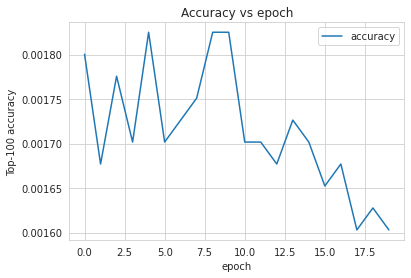

In [34]:
epochs = [i for i in range(20)]

plt.plot(epochs, modelhist_multitask.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

### Deep cross network

In [35]:
feature_names = ["userID", "itemID"]

In [36]:
vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [37]:
class DeepCrossNetwork(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["itemID", "userID"
                    ]
    #int_features = []

    self._all_features = str_features #+ int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    # # Compute embeddings for int features.
    # for feature_name in int_features:
    #   vocabulary = vocabularies[feature_name]
    #   self._embeddings[feature_name] = tf.keras.Sequential(
    #       [tf.keras.layers.IntegerLookup(
    #           vocabulary=vocabulary, mask_value=None),
    #        tf.keras.layers.Embedding(len(vocabulary) + 1,
    #                                  self.embedding_dimension)
    # ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)

    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

In [38]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5,learning_rate=0.001):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DeepCrossNetwork(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate))
    models.append(model)

    model.fit(cached_train, epochs=epochs, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    rmses.append(metrics["RMSE"])
   
  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv}

In [39]:
epochs = 20
learning_rate = 0.001

In [40]:
dcn_result = run_models(use_cross_layer=True,
                           projection_dim=256,
                           deep_layer_sizes=[256, 256])

3/3 [==============================] - 0s 4ms/step - RMSE: 0.8741 - loss: 0.7801 - regularization_loss: 0.0000e+00 - total_loss: 0.7801


3/3 [==============================] - 0s 4ms/step - RMSE: 0.8764 - loss: 0.7845 - regularization_loss: 0.0000e+00 - total_loss: 0.7845


3/3 [==============================] - 0s 4ms/step - RMSE: 0.8739 - loss: 0.7800 - regularization_loss: 0.0000e+00 - total_loss: 0.7800


In [41]:
contant_df

,userID,itemID,date,rating,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,6357,98783,2004-09-01,5,chocolate orange fudge,98783,10,1535,2004-08-31,"['15-minutes-or-less', 'time-to-make', 'course...","[137.2, 10.0, 74.0, 0.0, 4.0, 20.0, 6.0]",9,['line a 8x8x2-inch baking pan with lightly bu...,this is so easy and yet it is probably the bes...,"['semi-sweet chocolate chips', 'sweetened cond...",4
1,55380,98783,2005-12-27,5,chocolate orange fudge,98783,10,1535,2004-08-31,"['15-minutes-or-less', 'time-to-make', 'course...","[137.2, 10.0, 74.0, 0.0, 4.0, 20.0, 6.0]",9,['line a 8x8x2-inch baking pan with lightly bu...,this is so easy and yet it is probably the bes...,"['semi-sweet chocolate chips', 'sweetened cond...",4
2,231054,98783,2007-12-10,5,chocolate orange fudge,98783,10,1535,2004-08-31,"['15-minutes-or-less', 'time-to-make', 'course...","[137.2, 10.0, 74.0, 0.0, 4.0, 20.0, 6.0]",9,['line a 8x8x2-inch baking pan with lightly bu...,this is so easy and yet it is probably the bes...,"['semi-sweet chocolate chips', 'sweetened cond...",4
3,189616,98783,2007-12-14,5,chocolate orange fudge,98783,10,1535,2004-08-31,"['15-minutes-or-less', 'time-to-make', 'course...","[137.2, 10.0, 74.0, 0.0, 4.0, 20.0, 6.0]",9,['line a 8x8x2-inch baking pan with lightly bu...,this is so easy and yet it is probably the bes...,"['semi-sweet chocolate chips', 'sweetened cond...",4
4,469903,98783,2007-12-17,5,chocolate orange fudge,98783,10,1535,2004-08-31,"['15-minutes-or-less', 'time-to-make', 'course...","[137.2, 10.0, 74.0, 0.0, 4.0, 20.0, 6.0]",9,['line a 8x8x2-inch baking pan with lightly bu...,this is so easy and yet it is probably the bes...,"['semi-sweet chocolate chips', 'sweetened cond...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50681,368078,31311,2008-12-22,5,stormy s reese s peanut butter cup cookies 2 ...,31311,18,37305,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[166.1, 14.0, 13.0, 5.0, 6.0, 12.0, 6.0]",8,['place unwrapped peanut butter cups in freeze...,refrigerated cookie dough and mini peanut butt...,"['miniature peanut butter cups', 'peanut butte...",2
50682,727055,31311,2009-01-10,5,stormy s reese s peanut butter cup cookies 2 ...,31311,18,37305,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[166.1, 14.0, 13.0, 5.0, 6.0, 12.0, 6.0]",8,['place unwrapped peanut butter cups in freeze...,refrigerated cookie dough and mini peanut butt...,"['miniature peanut butter cups', 'peanut butte...",2
50683,242484,31311,2009-09-29,5,stormy s reese s peanut butter cup cookies 2 ...,31311,18,37305,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[166.1, 14.0, 13.0, 5.0, 6.0, 12.0, 6.0]",8,['place unwrapped peanut butter cups in freeze...,refrigerated cookie dough and mini peanut butt...,"['miniature peanut butter cups', 'peanut butte...",2
50684,470351,31311,2009-12-16,5,stormy s reese s peanut butter cup cookies 2 ...,31311,18,37305,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[166.1, 14.0, 13.0, 5.0, 6.0, 12.0, 6.0]",8,['place unwrapped peanut butter cups in freeze...,refrigerated cookie dough and mini peanut butt...,"['miniature peanut butter cups', 'peanut butte...",2


In [54]:
contant_df['nutrition_f2']=contant_df['nutrition'].str.split(',', expand = True)[1]
contant_df['nutrition_f2']=contant_df['nutrition_f2'].astype(float)
contant_df['nutrition_f1']=contant_df['nutrition'].str.split(',', expand = True)[0]
contant_df['nutrition_f1']=contant_df['nutrition_f1'].str.replace('[','').astype(float)
contant_df['nutrition_f3']=contant_df['nutrition'].str.split(',', expand = True)[2]
contant_df['nutrition_f3']=contant_df['nutrition_f3'].astype(float)
contant_df['nutrition_f4']=contant_df['nutrition'].str.split(',', expand = True)[3]
contant_df['nutrition_f4']=contant_df['nutrition_f4'].astype(float)
contant_df['nutrition_f5']=contant_df['nutrition'].str.split(',', expand = True)[4]
contant_df['nutrition_f5']=contant_df['nutrition_f5'].str.replace('[','').astype(float)
contant_df['nutrition_f6']=contant_df['nutrition'].str.split(',', expand = True)[5]
contant_df['nutrition_f6']=contant_df['nutrition_f6'].astype(float)

contant_df['nutrition_f7']=contant_df['nutrition'].str.split(',', expand = True)[6]
contant_df['nutrition_f7']=contant_df['nutrition_f7'].str.replace(']','').astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  from ipykernel import kernelapp as app


In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

contant_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']]=scaler.fit_transform(contant_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']])

nutrition_df=contant_df[['nutrition_f1','nutrition_f2','nutrition_f3','nutrition_f4','nutrition_f5','nutrition_f6','nutrition_f7']]

processing for k=1
processing for k=2
processing for k=3
processing for k=4
processing for k=5
processing for k=6
processing for k=7
processing for k=8
processing for k=9
processing for k=10
processing for k=11
processing for k=12
processing for k=13
processing for k=14
processing for k=15
processing for k=16
processing for k=17
processing for k=18
processing for k=19
processing for k=20
processing for k=21
processing for k=22
processing for k=23
processing for k=24
processing for k=25
processing for k=26
processing for k=27
processing for k=28
processing for k=29
processing for k=30
processing for k=31
processing for k=32
processing for k=33
processing for k=34
processing for k=35
processing for k=36
processing for k=37
processing for k=38
processing for k=39
processing for k=40


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


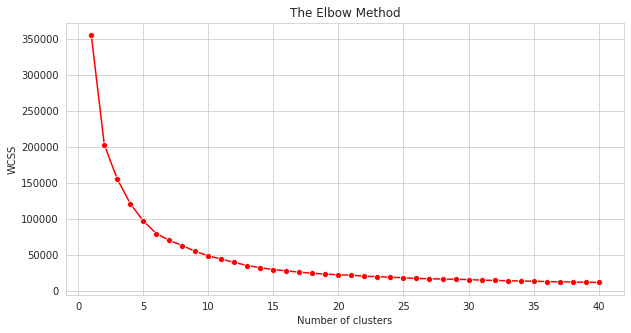

In [56]:

from sklearn.cluster import KMeans

num_clust = 40

wcss = []

for i in range(1, num_clust+1):
    print(f'processing for k={i}')
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(nutrition_df)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))

sns.lineplot(range(1, num_clust+1), wcss,marker='o',color='red')

plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


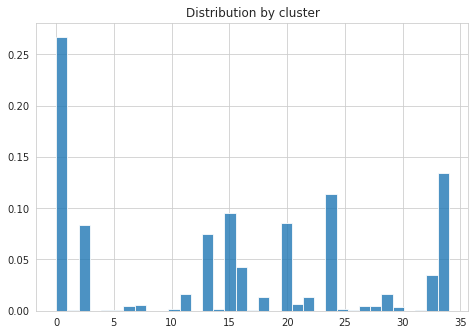

In [57]:
num_clust = 35

kmeans = KMeans(n_clusters = num_clust, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(nutrition_df)

nutrition_df.loc[:, 'cluster'] = y_kmeans

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    y_kmeans,
    bins=num_clust,
    density=True,
    alpha=0.8
)

plt.title('Distribution by cluster')
plt.show()

In [58]:
contant_df['cluster']=nutrition_df['cluster']

In [62]:
contant_df=contant_df[['userID','itemID','rating','cluster']]

In [63]:
interactions_dict = contant_df.groupby(['userID', 
                                      'itemID',
                                      'cluster'])[ 'rating'].sum().reset_index()


In [66]:
interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

## item features
items_dict = contant_df[['itemID']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

## map the features in interactions and items

# Select the basic features.
interactions = interactions.map(lambda x: {
    'userID' : str(x['userID']), 
    'cluster' : str(x['cluster']),
    'itemID' : str(x['itemID']), 
    'rating' : int(x['rating']),
    
})

items = items.map(lambda x: str(x['itemID']))
clusters = interactions.map(lambda x: str(x['cluster']))

In [67]:
unique_items = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["userID"]))))
unique_cluster = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["cluster"]))))

In [68]:
total=interactions.__len__().numpy()
train_size=(int) (total * .8 )
test_size=(int) (total * .2 )

In [69]:
tf.random.set_seed(42)
shuffled = interactions.shuffle(train_size, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(train_size)
test = shuffled.skip(train_size).take(test_size)

In [71]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        
        self.embedding_dimension = 32
        max_tokens = 10_000

        ## user id
        self.user_embedding = tf.keras.Sequential([
                                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                                    vocabulary=unique_user_ids, mask_token=None),
                                                    tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
                                                    ])
       
        
              
        # authors
        self.cluster_embedding = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                    vocabulary=unique_cluster, mask_token=None),
                                  tf.keras.layers.Embedding(len(unique_cluster) + 1, self.embedding_dimension)
                                ])
        
        # self.author_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        #                                                                                 max_tokens=max_tokens)
        # self.author_text_embedding = tf.keras.Sequential([
        #                           self.author_vectorizer,
        #                           tf.keras.layers.Embedding(max_tokens, self.embedding_dimension, mask_zero=True),
        #                           tf.keras.layers.GlobalAveragePooling1D(),
        #                         ])

        # self.author_vectorizer.adapt(clusters)
        

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
            self.user_embedding(inputs["userID"]),
            self.cluster_embedding(inputs["cluster"]),
  
        ], axis=1)

In [72]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding user queries
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()
            

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                        kernel_initializer="glorot_uniform"))

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [73]:
class ItemModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        
        self.embedding_dimension = 32

        max_tokens = 10_000

        self.item_embedding = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=unique_item_ids,mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_ids) + 1, self.embedding_dimension)
        ])

        self.item_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=max_tokens)

        self.item_text_embedding = tf.keras.Sequential([
          self.item_vectorizer,
          tf.keras.layers.Embedding(max_tokens, self.embedding_dimension, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.item_vectorizer.adapt(items)
      
    def call(self, items):
        return tf.concat([
            self.item_embedding(items),
            self.item_text_embedding(items),
        ], axis=1)

In [74]:
class CandidateModel(tf.keras.Model):
    """Model for encoding items."""

    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding items.

        
        """
        super().__init__()

        self.embedding_model = ItemModel()

         # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                                kernel_initializer="glorot_uniform"))

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [75]:
class CrossDNNModel(tfrs.models.Model):

    def __init__(self, layer_sizes, rating_weight: float, retrieval_weight: float, projection_dim=None ):
        super().__init__()
        
        self.query_model : tf.keras.Model = QueryModel(layer_sizes)
        self.candidate_model : tf.keras.Model = CandidateModel(layer_sizes)
        
        ## rating and retrieval task.
        
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
                 
        self.retrieval_task : tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=items.batch(128).map(self.candidate_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def compute_loss(self, features, training=False):
        
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        ratings = features.pop("rating")
        
        query_embeddings = self.query_model({
            "userID": features["userID"],
            "cluster": features["cluster"],
          
        })
    
        item_embeddings = self.candidate_model(features["itemID"])       
        retrieval_loss = self.retrieval_task(query_embeddings, item_embeddings)
    
    
        return self.retrieval_task(query_embeddings, item_embeddings)

In [76]:
cached_train = train.shuffle(100_000).batch(32).cache()
cached_test = test.batch(32).cache()

model = CrossDNNModel([32], rating_weight=0.5, retrieval_weight=0.5, 
                      projection_dim=None)

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

modelhist_dcn=model.fit(cached_train, validation_data=cached_test,
        validation_freq=5, epochs=3)

metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Retrieval top-50 accuracy: {metrics['factorized_top_k/top_50_categorical_accuracy']:.3f}.")
print(f"Retrieval top-10 accuracy: {metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}.")
print(f"Retrieval top-5 accuracy: {metrics['factorized_top_k/top_5_categorical_accuracy']:.3f}.")
print(f"Retrieval top-1 accuracy: {metrics['factorized_top_k/top_1_categorical_accuracy']:.3f}.")

Epoch 1/3
1268/1268 [==============================] - 266s 208ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 110.7375 - regularization_loss: 0.0000e+00 - total_loss: 110.7375
Epoch 2/3
1268/1268 [==============================] - 255s 201ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 110.7375 - regularization_loss: 0.0000e+00 - total_loss: 110.7375
Epoch 3/3
317/317 [===========================